In [1]:
import os
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plot
import cv2
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout, Conv2DTranspose, concatenate, Input, Activation
from tensorflow.keras import Model

# constants

In [2]:
training_images = "CamVid/train"
training_images_masks = "CamVid/train_labels"

validation_images = "CamVid/val/"
validation_images_masks = "CamVid/val_labels"

#resizing images
shape = 256

# Combine image paths and mask paths for easier access

In [3]:
def Loader(image_path, mask_path, size):
    image_mask_dict = { 'image' : [] , 'mask' : []}

    img_names = os.listdir('./' + image_path)
    mask_names = []

    #mask data is unordered so we have to add _L to the name

    for name in img_names:
        mask_names.append(re.sub(".png", "_L.png", name))

    for i in range (len(img_names)):
        image = plot.imread(image_path + "/" + img_names[i])
        mask = plot.imread(mask_path + "/" + mask_names[i])

        #resize
        image = cv2.resize(image, (size, size))
        mask = cv2.resize(mask, (size, size))

        image_mask_dict['image'].append(image)
        image_mask_dict['mask'].append(mask)

    return image_mask_dict


## Load our pictures

In [4]:
training = Loader(training_images, training_images_masks, shape)

val = Loader(validation_images, validation_images_masks, shape)

# Display a test


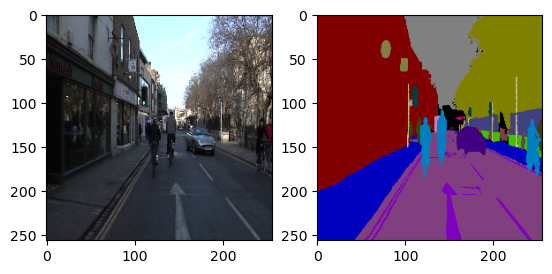

In [19]:
plot.subplot(1,2,1)
plot.imshow(training['image'][240])
plot.subplot(1,2,2)
plot.imshow(training['mask'][240])
plot.show()


# Model


the idea is to first downsample the images mulitple times and then reverse it with upsampling with a U-Net model

In [6]:
# start values;
no_filters = 32
dropout_rate = 0.5

In [7]:
inputs = Input((shape, shape, 3))

# Downsampling 

#1
conD1 = Conv2D(
    filters = no_filters,
    kernel_size = 3,
    padding = "same",
    activation ="relu"
)(inputs)

#Two layers might lead to higher accuracy
conD1 = Conv2D(
    filters = no_filters,
    kernel_size = 3,
    padding = "same",
    activation ="relu"
)(conD1)

poolD1 = MaxPool2D(
    pool_size = 2
)(conD1)

poolD1 = Dropout(dropout_rate)(poolD1)

#2
conD2 = Conv2D(
    filters = no_filters * 2,
    kernel_size = 3,
    padding = "same",
    activation ="relu"
)(poolD1)

conD2 = Conv2D(
    filters = no_filters * 2,
    kernel_size = 3,
    padding = "same",
    activation ="relu"
)(conD2)

poolD2 = MaxPool2D(
    pool_size = 2
)(conD2)

poolD2 = Dropout(dropout_rate)(poolD2)

#3
conD3 = Conv2D(
    filters = no_filters * 4,
    kernel_size = 3,
    padding = "same",
    activation ="relu"
)(poolD2)

conD3 = Conv2D(
    filters = no_filters * 4,
    kernel_size = 3,
    padding = "same",
    activation ="relu"
)(conD3)

poolD3 = MaxPool2D(
    pool_size = 2
)(conD3)

poolD3 = Dropout(dropout_rate)(poolD3)

#4
conD4 = Conv2D(
    filters = no_filters * 8,
    kernel_size = 3,
    padding = "same",
    activation ="relu"
)(poolD3)

conD4 = Conv2D(
    filters = no_filters * 8,
    kernel_size = 3,
    padding = "same",
    activation ="relu"
)(conD4)

poolD4 = MaxPool2D(
    pool_size = 2
)(conD4)

poolD4 = Dropout(dropout_rate)(poolD4)


#5 gotta stop at some point
conMax = Conv2D(
    filters = no_filters * 16,
    kernel_size = 3,
    padding = "same",
    activation ="relu"
)(poolD4)


#Upsampling 

#based on https://en.wikipedia.org/wiki/U-Net#/media/File:Example_architecture_of_U-Net_for_producing_k_256-by-256_image_masks_for_a_256-by-256_RGB_image.png

# expands last Convolution
poolU4 = Conv2DTranspose(
    filters = no_filters * 8,
    kernel_size = 3,
    strides = 2,
    padding = "same"
)(conMax)

# concatenate with last-1 to and downsample to same size

poolU4 = concatenate([poolU4, conD4])
poolU4 = Dropout(dropout_rate)(poolU4)
conU4 = Conv2D(
    filters = no_filters * 8,
    kernel_size = 3,
    padding = "same",
    activation ="relu"
)(poolU4)

conU4 = Conv2D(
    filters = no_filters * 8,
    kernel_size = 3,
    padding = "same",
    activation ="relu"
)(conU4)


#Repeat until same image size as input.
poolU3 = Conv2DTranspose(
    filters = no_filters * 4,
    kernel_size = 3,
    strides = 2,
    padding = "same"
)(conU4)


poolU3 = concatenate([poolU3, conD3])
poolU3 = Dropout(dropout_rate)(poolU3)
conU3 = Conv2D(
    filters = no_filters * 8,
    kernel_size = 3,
    padding = "same",
    activation ="relu"
)(poolU3)

conU3 = Conv2D(
    filters = no_filters * 8,
    kernel_size = 3,
    padding = "same",
    activation ="relu"
)(conU3)



poolU2 = Conv2DTranspose(
    filters = no_filters * 2,
    kernel_size = 3,
    strides = 2,
    padding = "same"
)(conU3)


poolU2 = concatenate([poolU2, conD2])
poolU2 = Dropout(dropout_rate)(poolU2)
conU2 = Conv2D(
    filters = no_filters * 2,
    kernel_size = 3,
    padding = "same",
    activation ="relu"
)(poolU2)

conU2 = Conv2D(
    filters = no_filters * 2,
    kernel_size = 3,
    padding = "same",
    activation ="relu"
)(conU2)


poolU1 = Conv2DTranspose(
    filters = no_filters * 2,
    kernel_size = 3,
    strides = 2,
    padding = "same"
)(conU2)


poolU1 = concatenate([poolU1, conD1])
poolU1 = Dropout(dropout_rate)(poolU1)
conU1 = Conv2D(
    filters = no_filters * 2,
    kernel_size = 3,
    padding = "same",
    activation ="relu"
)(poolU1)

conU1 = Conv2D(
    filters = no_filters * 2,
    kernel_size = 3,
    padding = "same",
    activation ="relu"
)(conU1)


output = Conv2D(3, (1 , 1), activation= 'sigmoid')(conU1)

model = Model(
    inputs = inputs,
    outputs = output
)


model.compile(optimizer="Adam", loss='binary_crossentropy', metrics=['accuracy'])



Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



In [8]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 32  9248        ['conv2d[0][0]']                 
                                )                                                             

# Training   

In [22]:
fitData = model.fit(np.array(training['image']), np.array(training['mask']), epochs = 100, verbose= 0)

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13GFamilyCommandBuffer: 0x3a42ebbc0>
    label = <none> 
    device = <AGXG13GDevice: 0x17a271800>
        name = Apple M1 
    commandQueue = <AGXG13GFamilyCommandQueue: 0x103bf0600>
        label = <none> 
        device = <AGXG13GDevice: 0x17a271800>
            name = Apple M1 
    retainedReferences = 1
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13GFamilyCommandBuffer: 0x2fe06bd90>
    label = <none> 
    device = <AGXG13GDevice: 0x17a271800>
        name = Apple M1 
    commandQueue = <AGXG13GFamilyCommandQueue: 0x103bf0600>
        label = <none> 
        device = <AGXG13GDevice: 0x17a271800>
            name = Apple M1 
    retainedReference

In [23]:
model.save("imageSegmentation100epochs_filters32_15051354.h5")

In [9]:
lModel = tf.keras.models.load_model("imageSegmentation100epochs_filters32_15051354.h5")

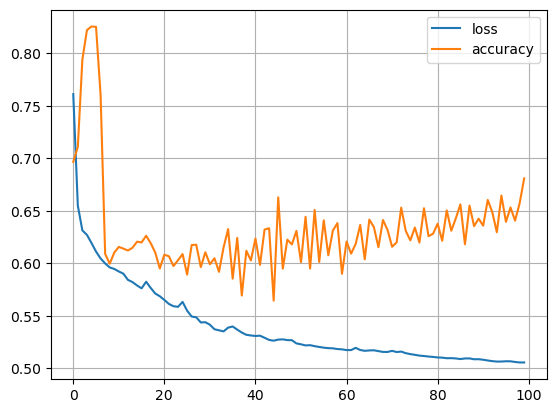

In [25]:
plot.plot(fitData.history['loss'], label= 'loss')
plot.plot(fitData.history['accuracy'], label= 'accuracy')
plot.legend()
plot.grid(True)

In [11]:
lModel.evaluate(np.array(val['image']), np.array(val['mask']))

2023-05-15 19:58:09.841164: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


4/4 [==============================] - 4s 822ms/step - loss: 0.5294 - accuracy: 0.5254


[0.5294488668441772, 0.5254482626914978]

In [10]:
testData = np.array(val['image'][0:5])


In [15]:
predictions = lModel.predict(testData)
print(predictions)

1/1 [==============================] - 0s 236ms/step
[[[[4.75405276e-01 4.51515198e-01 3.89508814e-01]
   [4.64293718e-01 4.50115681e-01 3.40010822e-01]
   [4.71610308e-01 4.48939949e-01 2.74693698e-01]
   ...
   [5.05293012e-01 7.86850005e-02 4.05050628e-02]
   [4.88860071e-01 1.01206712e-01 5.23496531e-02]
   [4.85233098e-01 1.68193564e-01 1.22175902e-01]]

  [[4.66149181e-01 4.51057673e-01 3.50903153e-01]
   [4.52896476e-01 4.66378391e-01 3.02757144e-01]
   [4.62863773e-01 4.45933759e-01 1.91477850e-01]
   ...
   [4.80603933e-01 3.20478864e-02 1.17371324e-02]
   [4.76602435e-01 4.12127636e-02 1.42831896e-02]
   [4.84422684e-01 9.66743752e-02 5.48028983e-02]]

  [[4.54899162e-01 4.48855579e-01 3.18886042e-01]
   [4.49268103e-01 4.82844830e-01 2.62238801e-01]
   [4.67035264e-01 4.38458711e-01 1.52164906e-01]
   ...
   [4.72979546e-01 2.20268648e-02 7.10927742e-03]
   [4.67514545e-01 2.65156087e-02 8.05297028e-03]
   [4.84514117e-01 6.98803738e-02 3.43466662e-02]]

  ...

  [[1.0821571

In [16]:
# 
for i in range(len(predictions)):
    predictions[i] = cv2.merge((predictions[i,:,:,0],predictions[i,:,:,1],predictions[i,:,:,2]))

Text(0.5, 1.0, 'actual mask')

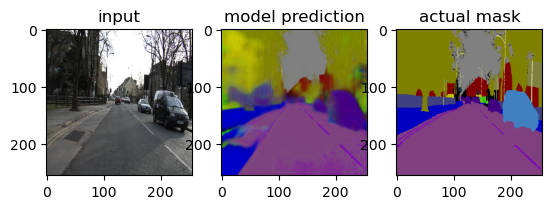

In [17]:
plot.subplot(1,3,1)
plot.imshow(val['image'][4])
plot.title('input')

plot.subplot(1,3,2)
plot.imshow(predictions[4])
plot.title('model prediction')

plot.subplot(1,3,3)
plot.imshow(val['mask'][4])
plot.title('actual mask')

Text(0.5, 1.0, 'image with actual mask')

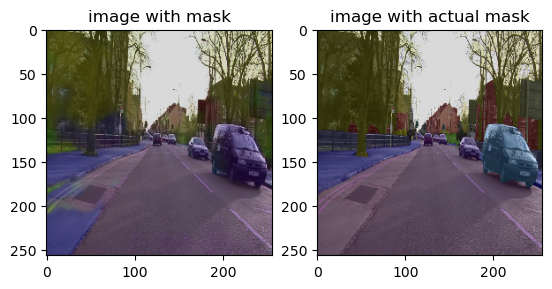

In [18]:
plot.subplot(1,2,1)
plot.imshow(val['image'][4])
plot.imshow(predictions[4], alpha=0.3)
plot.title('image with mask')

plot.subplot(1,2,2)
plot.imshow(val['image'][4])
plot.imshow(val['mask'][4], alpha=0.3)
plot.title('image with actual mask')

